**Oreum Industries Internal Project, 2024Q3**

---

# 201_AFT_Gompertz.ipynb

### Survival Regression Demo in `oreum_survival`

Demonstrate Survival Regression Modelling using Bayesian inference and a 
Bayesian workflow, specifically using the `pymc` & `arviz` ecosystem.

+ We extend our basic understanding with worked examples of parametric models in the AFT
  architecture family, using our real-world observational censored dataset.
+ Specifically: **A Parametric Regression aka Accelerated Failure Time Model: Gompertz**

## Contents

+ [Setup](#Setup)

+ [0. Load Dataset](#0.-Load-Dataset)

+ [1. Model Description](#1.-Model-Description)

+ [2. Custom Bayesian Model `GompertzRegression`](#2.-Custom-Bayesian-Model-`GompertzRegression`)

---

---


# Setup

## Imports

In [ ]:
import sys
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from oreum_core import curate, eda
from oreum_core import model_pymc as mt
from pyprojroot.here import here
from scipy import stats

# prepend local project src files
module_path = here('src').resolve(strict=True)
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))

from engine import logger, utils
from model import aft, exponential

import warnings  # isort:skip # suppress seaborn, it's far too chatty

warnings.simplefilter(action='ignore', category=FutureWarning)  # isort:skip
import seaborn as sns

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/pymc/util.py:38: FutureWarning: dataset_to_point_list has been moved to backends.arviz. Importing from util will fail in a future release.
  warnings.warn(


##### Notebook config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

log = logger.get_logger('201_AFT_Gompertz', notebook=True)
_ = logger.get_logger('oreum_core', notebook=True)

## Local Functions and Global Vars

In [3]:
RNG = np.random.default_rng(seed=42)

## Data Connections and Helper Objects

In [4]:
csvio = curate.PandasCSVIO(here(Path('data', 'raw', 'verbatim')).resolve(strict=True))
ppqio = curate.PandasParquetIO(here(Path('data', 'prepared')).resolve(strict=True))
mdlio = mt.PYMCIO(here(Path('data', 'models')).resolve(strict=True))
figio = eda.FigureIO(here(Path('plots')).resolve(strict=True))

---

---

# 0. Load Dataset

In [5]:
dfr = csvio.read(fn='mastectomy', index_col='rowid')
eda.display_ht(dfr)

,time,event,metastized
rowid,,,
0,23,True,no
1,47,True,no
2,69,True,no
41,212,False,yes
42,217,False,yes
43,225,False,yes


'Shape: (44, 3), Memsize 0.0 MB'

##### Correct dtypes etc

In [6]:
df = dfr.copy()
df['pid'] = ['p{}'.format(x) for x in range(len(df))]
df = df.reset_index(drop=True).set_index('pid')
df.rename(columns={'time': 'duration', 'event': 'death', 'metastized': 'met'}, inplace=True)
df['death'] = df['death'].astype(bool)
df['met'] = df['met'].apply(lambda x: True if str(x).strip() == 'yes' else False)
eda.describe(df)

,28,3,33,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p28,p3,p33,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,68,70,109,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death,True,False,False,bool,0,NaN,NaN,2,True,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
met,True,False,True,bool,0,NaN,NaN,2,True,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Shape: (44, 4), Memsize 0.0 MB'

---

---

# 1. Model Description

## 1.1 We extend the Exponential AFT model to use a Gompertz likelihood distribution

This follows on in the AFT family in this project to create an Accelerated Failure Time (AFT) parametric regression model 
that uses a [Gompertz distribution](https://en.wikipedia.org/wiki/Gompertz_distribution) for $\hat{\pi}(t)$. A lot of 
the core model architecture is the same, for example the `CustomDist` to handle right-censoring.


Modelling $\pi(t) \sim \text{Gompertz}(t\ |\ \eta, \sigma)$ can be useful because the Gompertz has a hazard function 
$\lambda$ that's steeper towardend of the observation period, according to shape parameter $\eta$.

This means it can capture: 
+ Late-stage effects like cumulative / mutually reinforcing failures,  senior mortality etc


**NOTE:**

+ The data is the same, the general architecture of the model code is the same, what we're doing is testing a different 
  parametric form which may fit the data better. 
+ Now the Bayesian workflow kicks into gear, because we will be able to easily specify the complex model substructures,
  and demonstrate improvement over the `exponential_regression` model via the log-likelihood performance via LOO-PIT / ELPD.
+ Again refer to `000_Intro.ipynb` $\S \text{Preamble}$ for the myriad reasons this is a better general method to use.

## 1.2 Gompertz Model parameters



Intuition:
+ $\hat{\lambda}$ is an unnamed function, proportional to $t^{\alpha - 1}$
+ $\hat{\pi}$ is a [Gompertz](https://en.wikipedia.org/wiki/Gompertz_distribution) (truncated Gumbel) function with support $t \in [0, \infty)$
+ Also see useful discussion / parameterisations / derivations by
  [Monica Alexander](https://www.monicaalexander.com/posts/2018-02-15-gompertz/), [Random Services](https://www.randomservices.org/random/special/Gompertz.html), the [Max Planck Institute](https://www.demogr.mpg.de/papers/working/wp-2012-008.pdf), [R vignette for eha](https://cran.r-project.org/web/packages/eha/vignettes/gompertz.html), and [SO CV](https://stats.stackexchange.com/questions/317356/using-gompertz-distribution-for-survival-rate-prediction)

Showing the main functional relationships in uncensored form (left) and (where relevant $\longrightarrow$ on the right) the censored version

$$
\begin{aligned}
\lambda(t) &=\eta \gamma \exp \left( \gamma t \right)
        &\longrightarrow \eta \gamma \exp \left( \gamma t \right)^{d_{i}} \\
\Lambda(t) &= \eta \left( \exp \left( \gamma t \right) + 1 \right) \\
S(t) &= \exp \left( - \eta \left( \exp \left( \gamma t \right) - 1 \right) \right) \\
S^{-1}(u) &= \frac{1}{\gamma} \log \left(1 - \frac{\log(1 - u)}{\eta} \right) \\ 
\hat{\pi}(t) &\sim \eta \gamma \exp \left( \gamma t \right) \cdot \exp \left( - \eta \left( \exp \left( \gamma t \right) - 1 \right) \right)
        &\longrightarrow \eta \gamma \exp \left( \gamma t \right)^{d_{i}} \cdot \exp \left( - \eta \left( \exp \left( \gamma t \right) - 1 \right) \right) \\
    &\sim \text{Gompertz}(t\ |\ \eta, \gamma) \\
\text{... so:} \\
\log \mathcal{L}\ \hat{\pi}(t) &\sim \log \eta + \log \gamma + \gamma t - \eta \left( \exp \left( \gamma t \right) - 1 \right)
        &\longrightarrow \sum_{i} d_{i} \left( \log \eta + \log \gamma + \gamma t \right) - \eta \left( \exp \left( \gamma t \right) - 1 \right)\\
\end{aligned}
$$

Where:
+ shape $\eta > 0$ (NOTE in the literature this is often given as $\alpha$)
+ scale $\gamma > 0$ (NOTE in the literature this is often given as $\beta$ with the relationship $\gamma = \frac{1}{\beta}$)
+ $d_{i} \in {0, 1}$:

When:
  + $\eta \approx 0$, hazard later, increases over time e.g. senior mortality
  + $\eta >> 0$, hazard sooner, becomes closer to (a scaled) exponential
  + $\gamma = 1$, $\lambda$ is exponential

## 1.3 Building the linear submodel for regression

Regression considerations:
+ We should choose one parameter for the regression term $\beta^{T}\mathbf{x}$, or carefully manage the covariance between the two. 
+ Because $\eta$ affects the shape, we will set $\eta \sim \exp (\beta^{T}\mathbf{x})$

Prior considerations
+ So our hyperpriors with initial, reasonably uninformative values look like:

$$
\begin{aligned}
\sigma_{\beta} &\sim \text{InvGamma}(\alpha=2, \beta=2)   &\ \ \text{Shared variance for } \beta, \mathbb{E} \sim 2 \\
\beta &\sim \text{Normal}(\mu=-3, \sigma=\sigma_{\beta})  &\ \ \text{Unpooled } \beta, \mathbb{E} \sim -3 \\
\eta &\sim \exp (\mathbf{\beta}^{T}\mathbf{x})         &\ \ \text{Regression prior for } \eta, \mathbb{E} \approx[5e^{-2}, 2e^{-3}]\\
\gamma &\sim \text{InvGamma}(\alpha=11, \beta=1)           &\ \ \text{Pooled } \gamma, \mathbb{E} \sim 0.1 \\
\end{aligned}
$$

+ Do randomly generated times $t$ look reasonable?

$$
\begin{aligned}
u &\sim \text{Uniform}(0, 1) \\
\hat{t} &\sim \hat{S}^{-1}(u) \\
        &\sim \frac{1}{\gamma} \log \left(1 - \frac{\log(1 - u)}{\eta} \right) \\
        &\sim 1/0.1 * \log \left(1 - \frac{\log(1 - u)}{5e{-2}} \right) \text{, when all at } \mathbb{E} \\
        &\approx \begin{cases}
            16 & \textrm{if } u = 0.01 \\
            75 & \textrm{if } u = 0.99 \\
        \end{cases}
\end{aligned}
$$

+ This is a narrow span of days `duration`, compared to our dataset, but in the right ballpark to start

## 1.4 Illustration of functions to aid intuition

Modify $\eta$

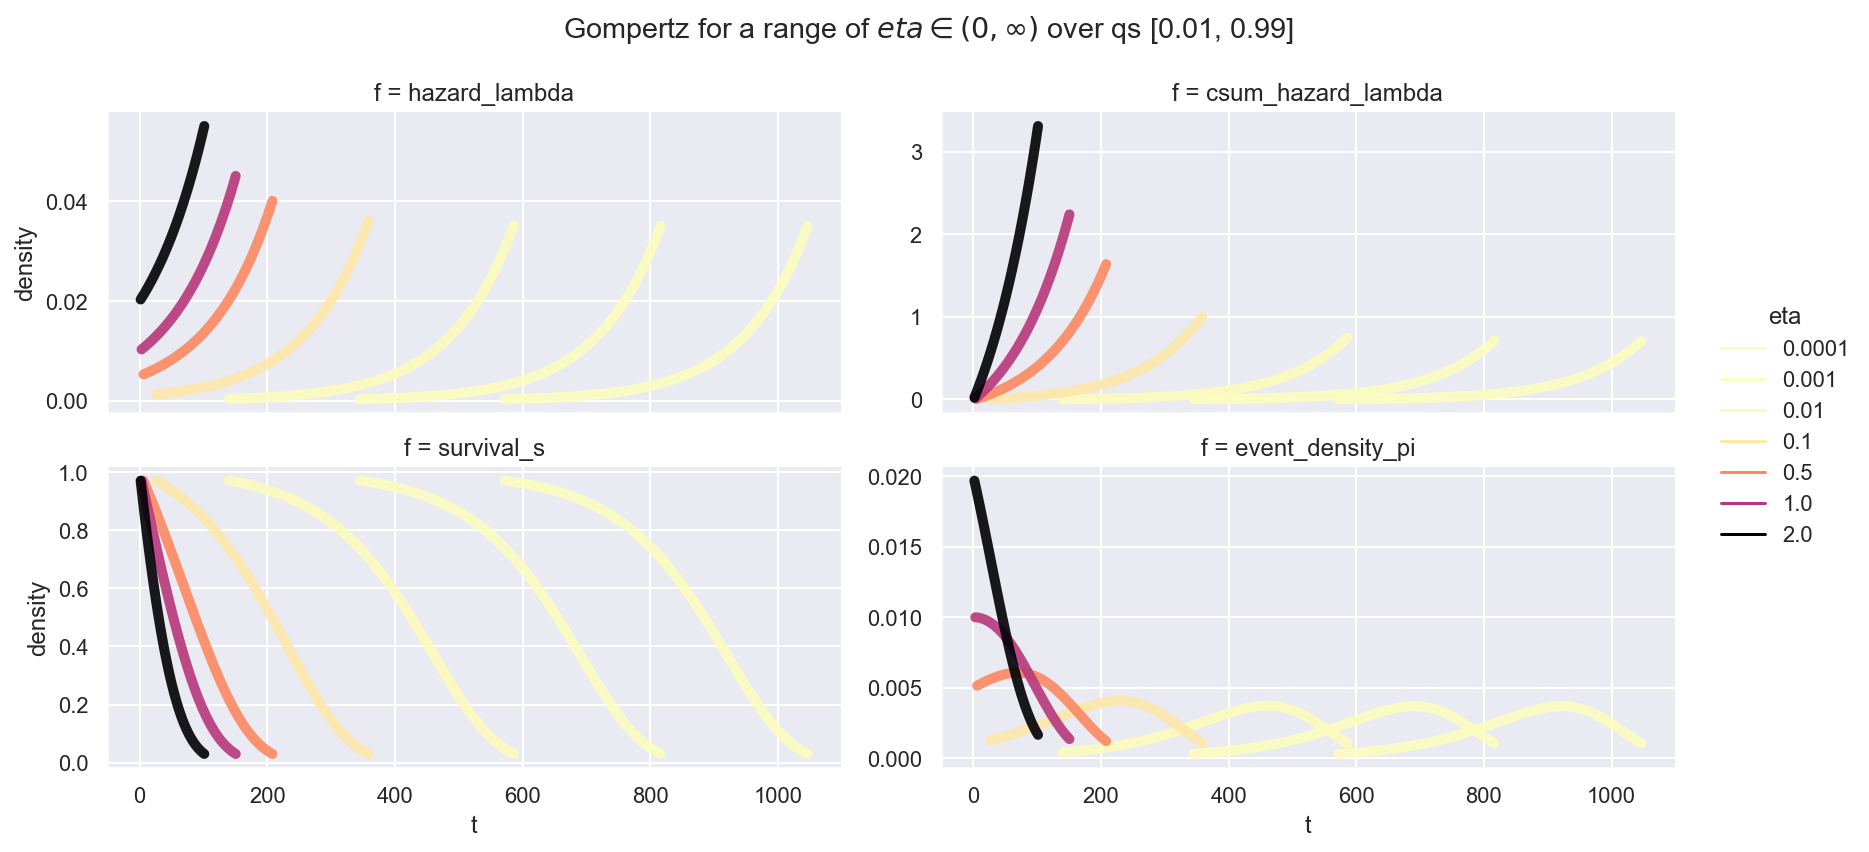

In [7]:
etas = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 2]
gamma = 0.01
dff = pd.concat([utils.get_fs(stats.gompertz(c=e, scale=1 / gamma), {'eta': e}) for e in etas])
_ = utils.plot_f(dff, 'Gompertz', 'eta')

Modify $\gamma$

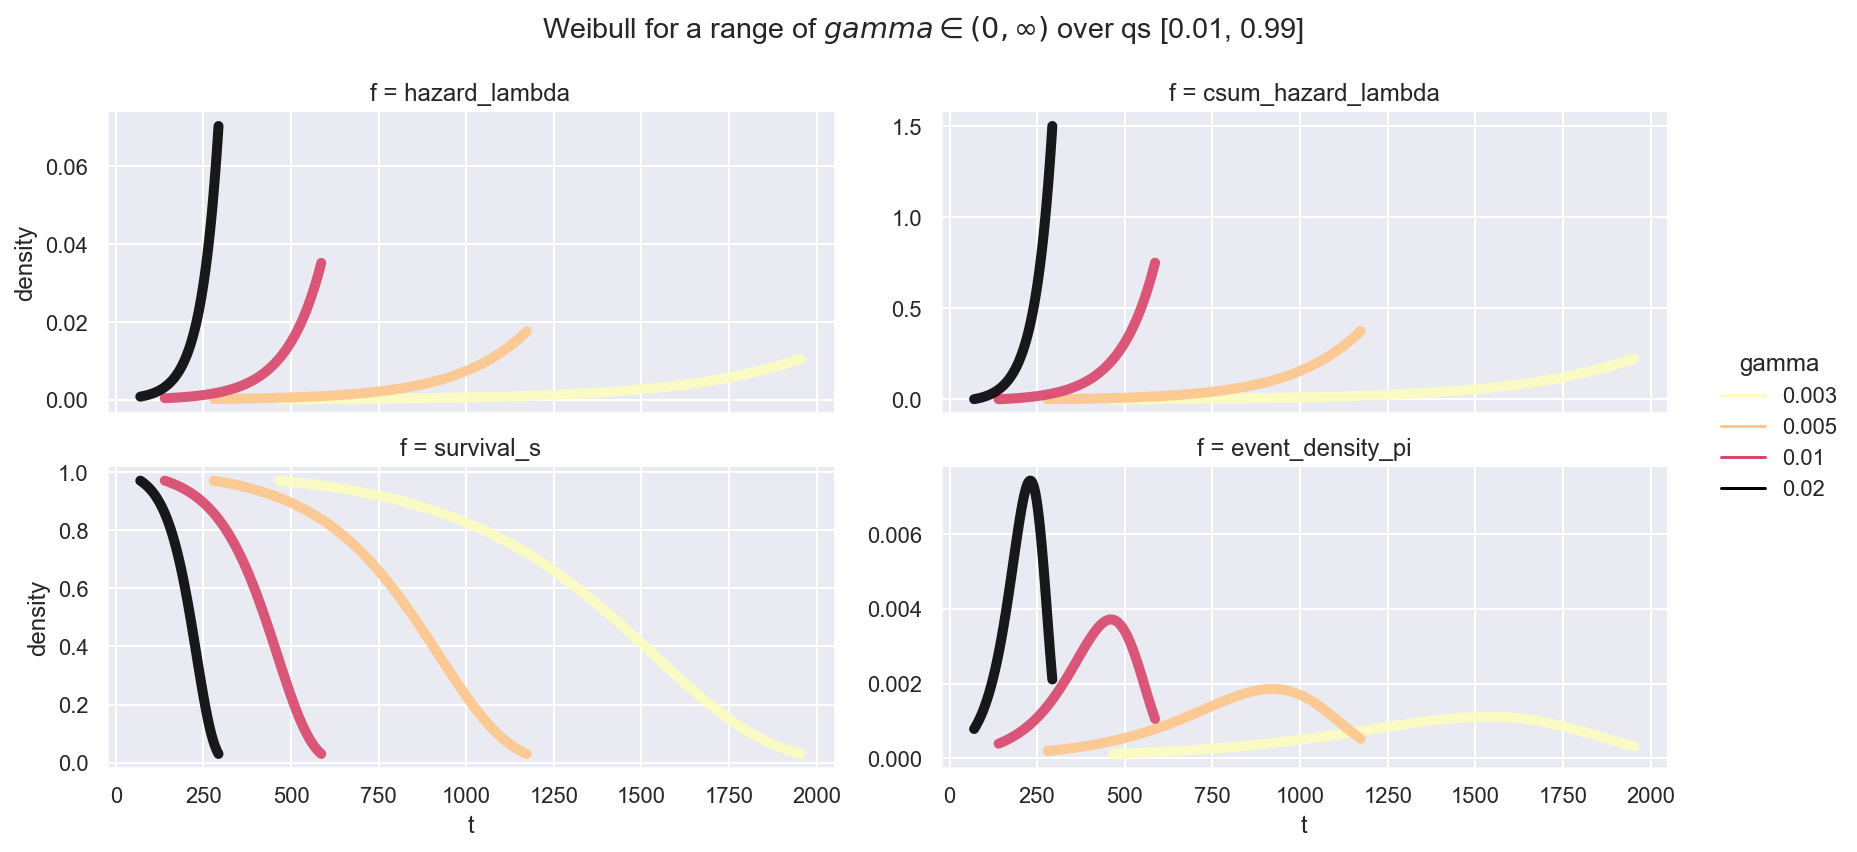

In [8]:
eta = 1e-2
gammas = [0.003, 0.005, 0.01, 0.02]
dff = pd.concat([utils.get_fs(stats.gompertz(c=eta, scale=1 / g), {'gamma': g}) for g in gammas])
_ = utils.plot_f(dff, 'Weibull', 'gamma')

---

---

# 2. Custom Bayesian Model `GompertzRegression`

## 2.0 Prepare & Transform Dataset for Linear Model

This is a preparatory step to transform the observational data into a form for
use in the custom Bayesian models. We will use this transformed dataset `dfx` 
in all subsequent models where possible

NOTE:

+ For this example Notebook we will _not_ partition into train & holdout sets
  (see `README.md ## 5. Data Standards` for terminology)
+ Instead we will simply fit the entire dataset and evaluate in-sample using
  Pareto-smoothed Leave-One-Out (LOO-PIT) cross-validation testing
+ This means we still follow our standard process for preparation, 
  transformation, standardization, but abbreviate to `dfa` only


In-house preferred process (transformation, standardization) to create `dfx` for model usage 

In [9]:
dfx_creator = utils.ProjectDFXCreator()
dfx = dfx_creator.get_dfx(df)
eda.describe(dfx)

,3,30,36,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p3,p30,p36,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,70,76,118,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death_t_true,0,0,1,int64,0,0.0,18.0,NaN,NaN,NaN,26.0,0.59,0.5,0.0,0.0,1.0,1.0,1.0
intercept,1.0,1.0,1.0,float64,0,0.0,0.0,NaN,NaN,NaN,44.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
met_t_true,0,1,1,int64,0,0.0,12.0,NaN,NaN,NaN,32.0,0.73,0.45,0.0,0.0,1.0,1.0,1.0


'Shape: (44, 5), Memsize 0.0 MB'

## 2.1 Build Model Object

`GompertzRegression` model imported from `src.model.aft.py` where it is fully defined

In [10]:
mdl_gr = aft.GompertzRegression(obs=dfx, fts_en=dfx_creator.fts_en, factor_map=dfx_creator.factor_map, obs_nm='dfx')
mdl_gr.build()
utils.display_rvs(mdl_gr)
mdl_gr.debug()

'RVs for gompertz_regression, v1.0.0, dfx'

beta_s ~ InverseGamma(5, 1)

beta ~ Normal(-3, beta_s)

gamma ~ InverseGamma(11, 1)

eta ~ Deterministic(f(beta))

shat ~ Deterministic(f(gamma, beta))

point={'beta_s_log__': array(-1.38629436), 'beta': array([-3., -3.]), 'gamma_log__': array(-2.30258508)}

No problems found
point={'beta_s_log__': array(-1.38629436), 'beta': array([-3., -3.]), 'gamma_log__': array(-2.30258508)}

No problems found


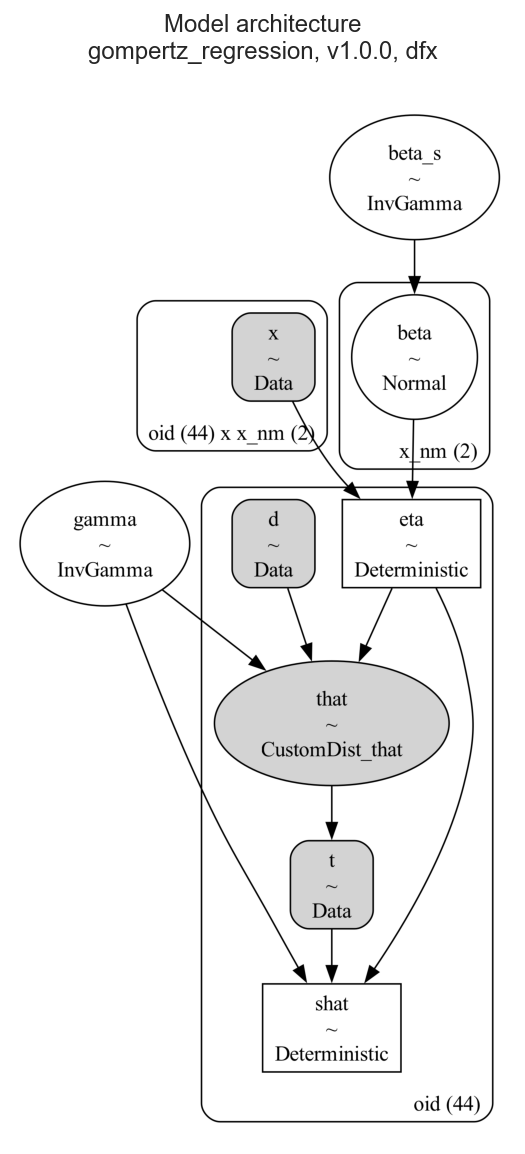

In [11]:
fqn = mdlio.write_graph(mdl_gr)  # output model graph to prove built
f = figio.read(fqn=fqn, title=f'Model architecture\n{mdl_gr.mdl_id}', figsize=(12, 8))

## 2.2 Sample Prior Predictive, View Diagnostics

In [12]:
mdl_gr.sample_prior_predictive(var_names=mdl_gr.rvs_prior + mdl_gr.rvs_ppc + mdl_gr.rvs_det, replace=True)

#### Evaluate PPC vs In-Sample Data

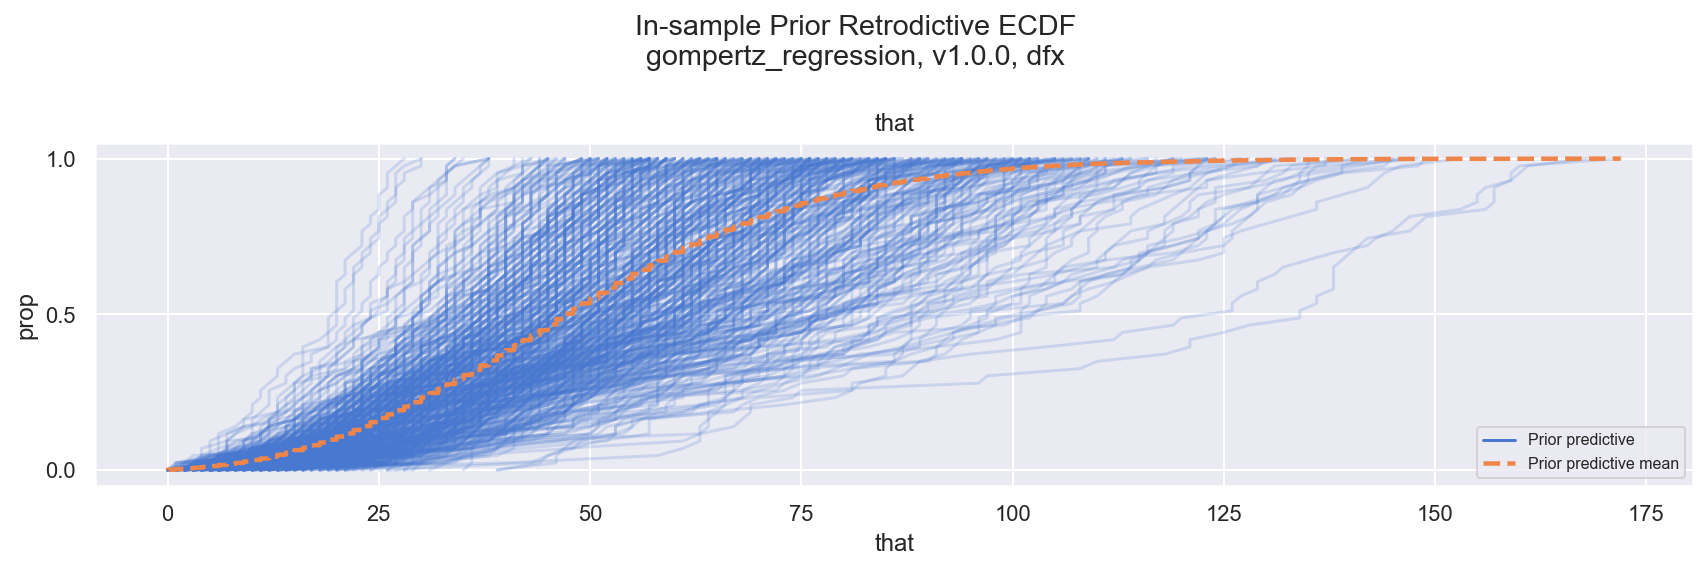

In [13]:
GRP = 'prior'
f = mt.plot_ppc(mdl=mdl_gr, group=GRP, var_names=['that'], insamp=True)

**Observe:**

+ Not a bad fit from the start, and range is valid 

#### Evaluate priors and hyperpriors

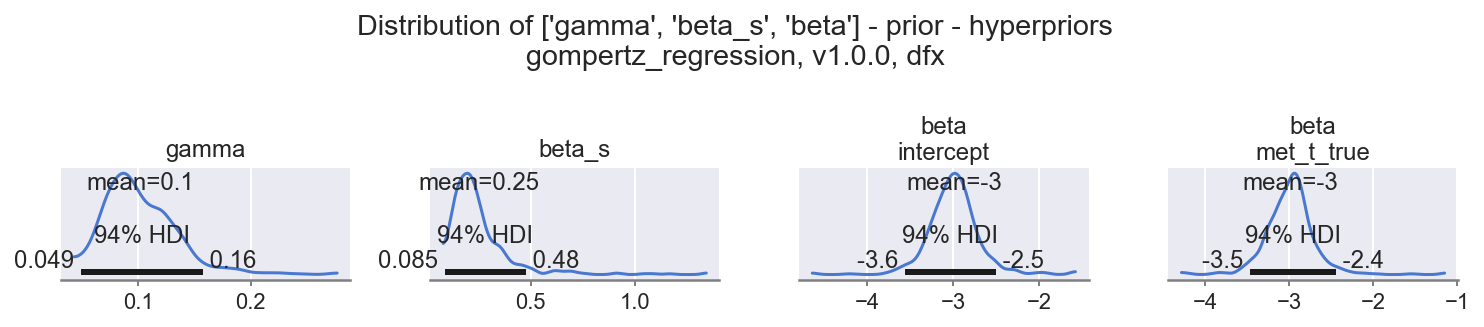

In [14]:
f = mt.facetplot_krushke(mdl=mdl_gr, group=GRP, txtadd='hyperpriors', rvs=mdl_gr.rvs_prior, m=4, rvs_hack=1)

**Observe:**

+ Reasonable $\mathbb{E}$ and HDI94 spans

Example selections of deterministic $\alpha$

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (44) in plot_posterior, generating only 40 plots
  warnings.warn(


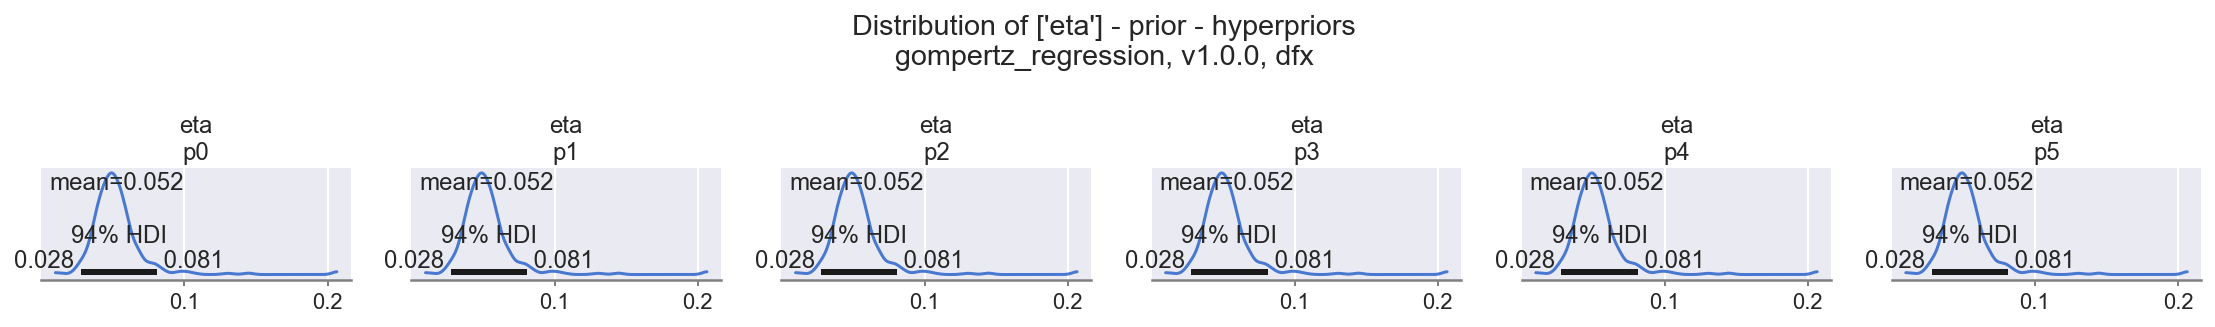

In [15]:
f = mt.facetplot_krushke(mdl=mdl_gr, group=GRP, txtadd='hyperpriors', rvs=mdl_gr.rvs_det, m=6, rvs_hack=0)

**Observe:**

+ Reasonable $\mathbb{E}$ and HDI94 spans

## 2.3 Sample Posterior, View Diagnostics

In [16]:
mdl_gr.sample(progressbar=True)
mdl_gr.sample_posterior_predictive(store_ppc=True, ppc_insample=True, var_names=mdl_gr.rvs_ppc)
mdlio.write_idata(mdl=mdl_gr)

Output()

Output()

PosixPath('/Users/jon/workspace/oreum/oreum_survival/data/models/idata_gompertz_regression_v100_dfx.netcdf')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma,0.019,0.002,0.016,0.022,0.000,0.000,947.0,1035.0,1.0
beta_s,1.782,0.621,0.874,2.891,0.019,0.014,1266.0,1164.0,1.0
beta[intercept],-3.808,0.511,-4.821,-2.917,0.019,0.013,764.0,820.0,1.0
beta[met_t_true],0.927,0.474,0.102,1.814,0.016,0.011,933.0,963.0,1.0


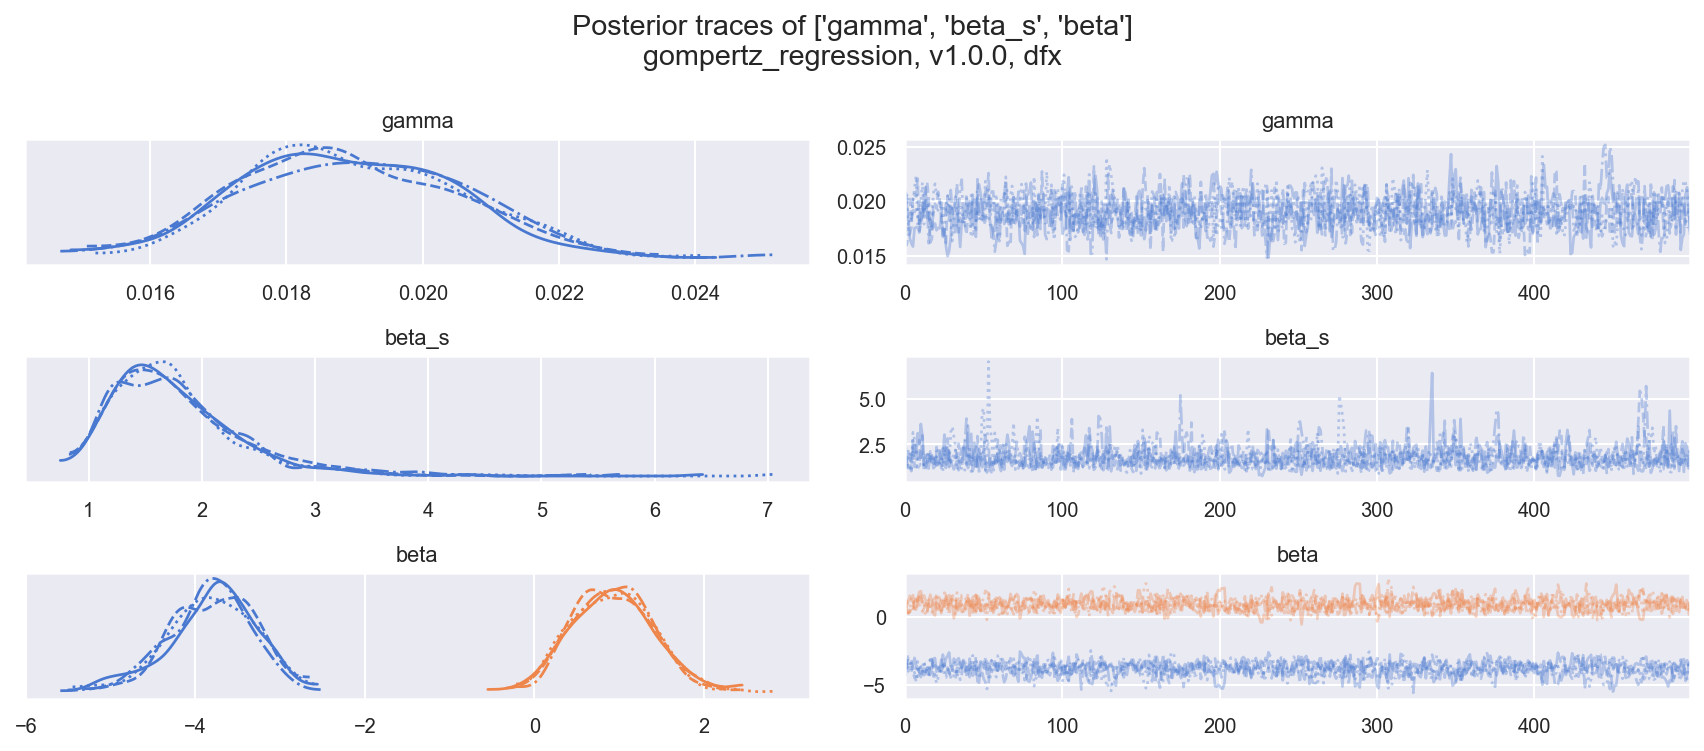

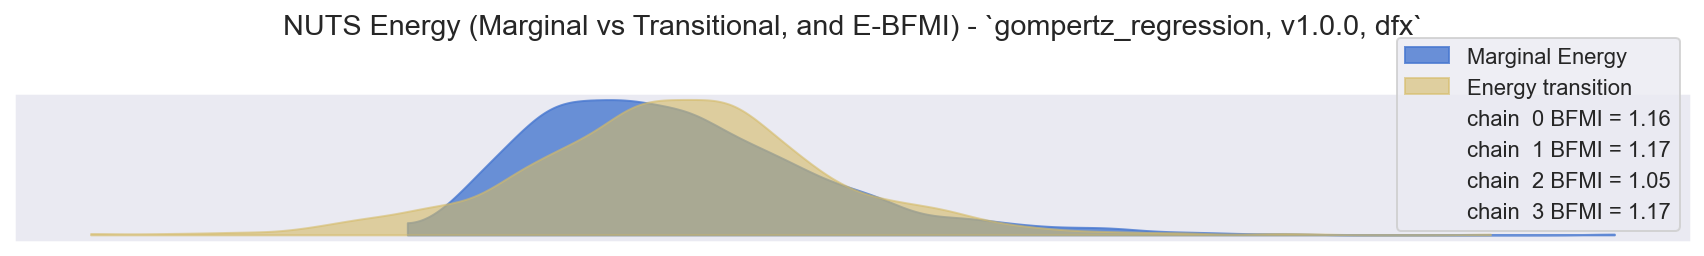

In [17]:
f = mt.plot_trace(mdl=mdl_gr, rvs=mdl_gr.rvs_prior, kind='trace')
f = mt.plot_energy(mdl=mdl_gr)
smry = mt.get_summary(mdl=mdl_gr, rvs=mdl_gr.rvs_prior)
smry

**Observe:**

+ Posterior distributions reasonably smooth and central
+ Samples well-mixed and well-behaved: `ess_bulk` is good, `r_hat` is good
+ Marginal energy | energy transition looks okay: `E-BFMI > 0.3` so [apparently reasonable](https://python.arviz.org/en/stable/api/generated/arviz.bfmi.html#arviz.bfmi)

## 2.4 Evaluate Posterior PPC (In-Sample) via ECDF

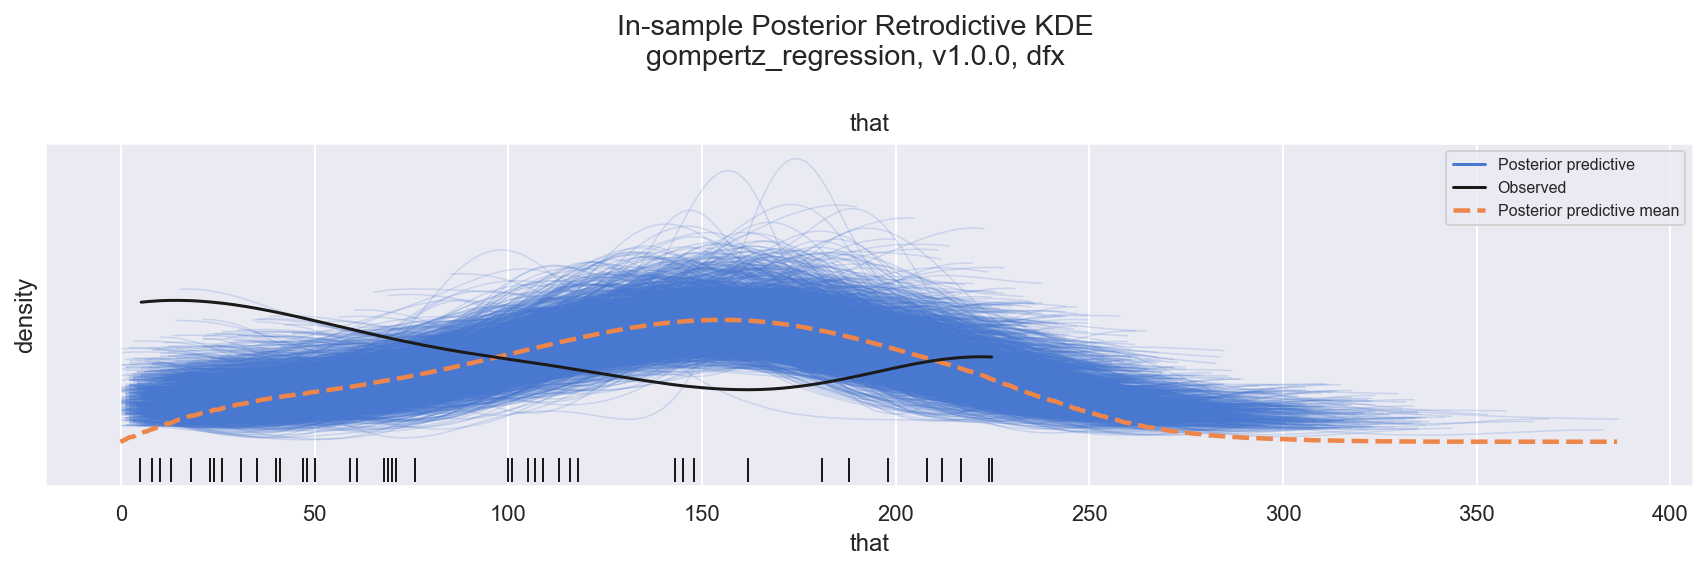

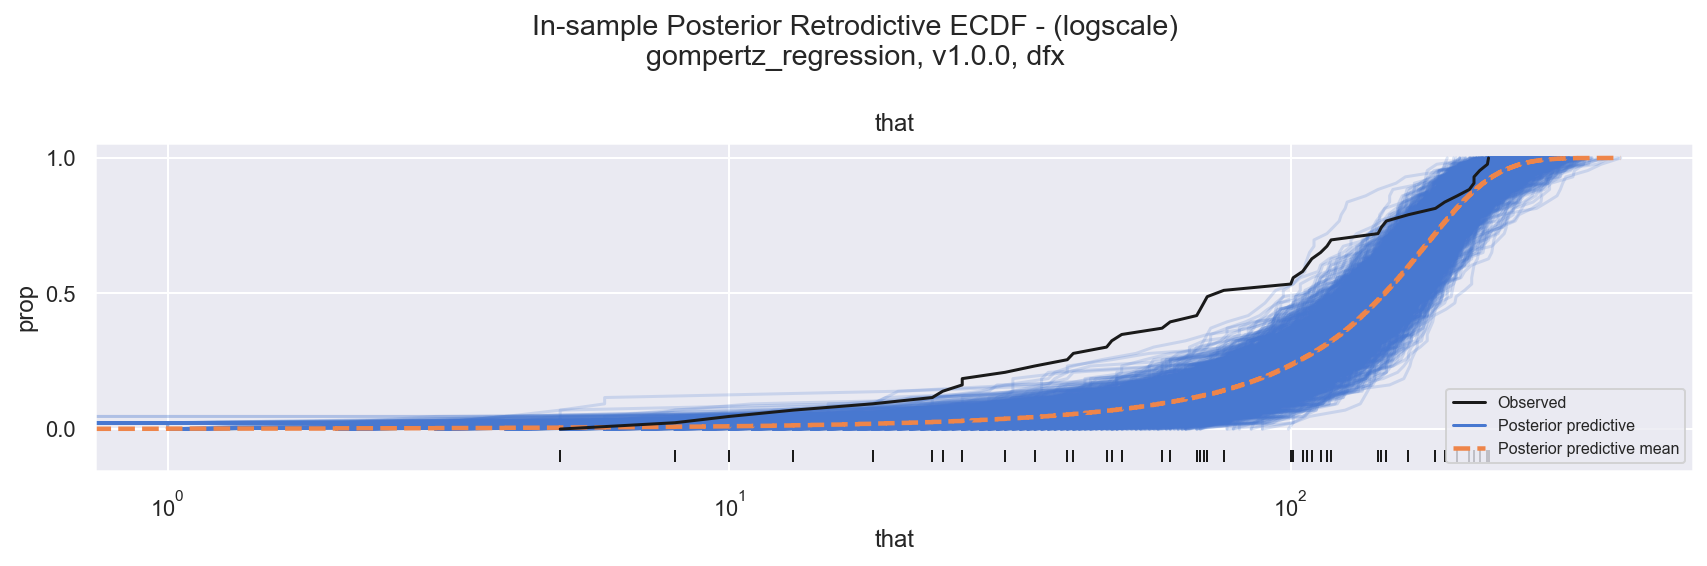

In [18]:
GRP = 'posterior'
f = mt.plot_ppc(mdl=mdl_gr, group=GRP, var_names=['that'], ecdf=False, insamp=True)
f = mt.plot_ppc(mdl=mdl_gr, group=GRP, var_names=['that'], insamp=True, logx=True)

**Observe:**

+ This is a pretty poor fit, underdispersed, although it doesn;t suffer the extreme right-tail that the Weibull model does
+ This fit is largely as expected given that the Gompertz assumes an increasing hazard function $\lambda$, 
  and we see in our dataset that the hazard is decreasing

## 2.5 Evaluate via LOO-PIT plots (In-Sample)

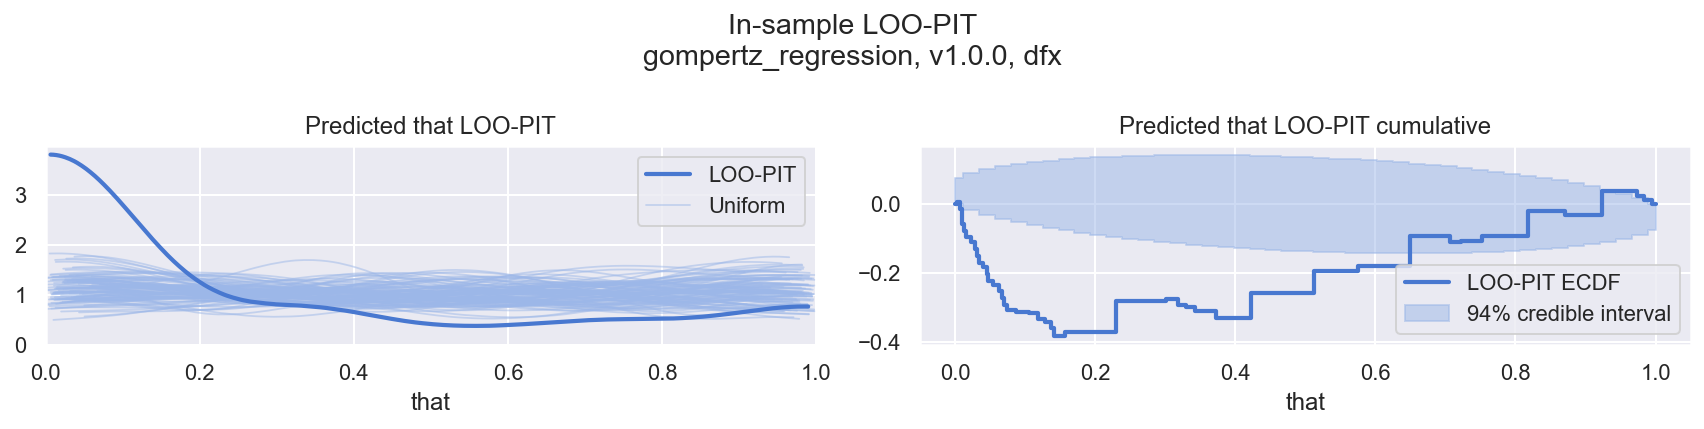

In [19]:
f = mt.plot_loo_pit(mdl_gr, data_pairs={'that': 'that'})

**Observe**

+ Pretty dreadful: underdispersed and biased

## 2.6 Compare Log-Likelihood vs other models

### 2.6.1 Reinstantiate earlier models for comparison

In [20]:
mdl_eu = exponential.ExponentialUnivariate(obs=dfx, fts_en=dfx_creator.fts_en, 
                                        factor_map=dfx_creator.factor_map, obs_nm='dfx')
mdl_eu.build()
mdl_eu_idata = mdlio.read_idata(mdl=mdl_eu)
mdl_eu.update_idata(idata=mdl_eu_idata)

In [21]:
mdl_er = exponential.ExponentialRegression(obs=dfx, fts_en=dfx_creator.fts_en, 
                                        factor_map=dfx_creator.factor_map, obs_nm='dfx')
mdl_er.build()
mdl_er_idata = mdlio.read_idata(mdl=mdl_er)
mdl_er.update_idata(idata=mdl_er_idata)

In [22]:
mdl_wr = aft.WeibullRegression(obs=dfx, fts_en=dfx_creator.fts_en, 
                                        factor_map=dfx_creator.factor_map, obs_nm='dfx')
mdl_wr.build()
mdl_wr_idata = mdlio.read_idata(mdl=mdl_wr)
mdl_wr.update_idata(idata=mdl_wr_idata)

### 2.6.2 Compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mdl_er\nexponential_regression_v102_dfx,0,-158.680736,2.083518,0.000000,0.871391,14.643382,0.000000,False,log
mdl_eu\nexponential_univariate_v102_dfx,1,-159.612908,1.179682,0.932172,0.128609,14.892223,1.575394,False,log
mdl_wr\nweibull_regression_v101_dfx,2,-160.238998,2.001912,1.558263,0.000000,15.218603,1.599212,False,log
mdl_gr\ngompertz_regression_v100_dfx,3,-184.091688,5.846561,25.410952,0.000000,16.989565,6.332707,False,log


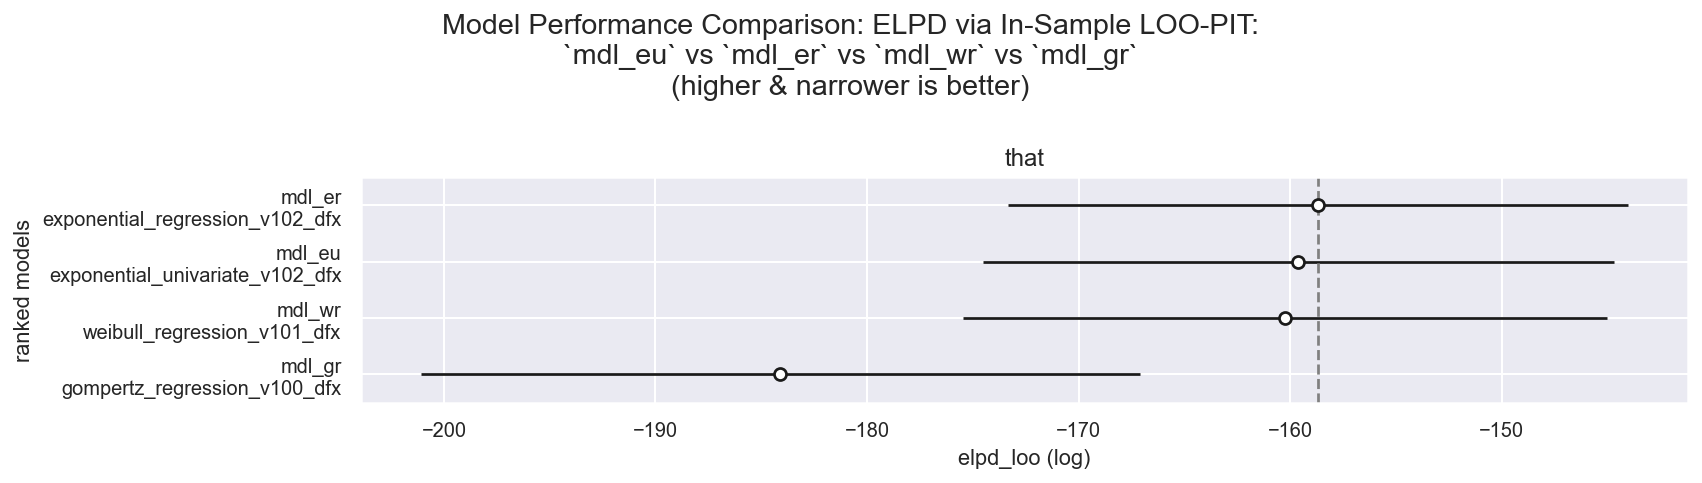

In [23]:
mdl_dict = {'mdl_eu': mdl_eu, 'mdl_er': mdl_er, 'mdl_wr': mdl_wr, 'mdl_gr': mdl_gr}
f, dcomp = mt.plot_compare(mdl_dict, yhats=['that'])
_ = [display(d) for d in dcomp.values()]

**Observe:**

+ `gompertz_regression` has the worst performance so far: this is not too surprising because it is suitable for age-increasing
  harzad functions $\lambda$, whereas we have already seen for this dataset the hazard _decreases_

In [24]:
del mdl_eu, mdl_er, mdl_wr

## 2.7 Evaluate Posterior Parameters

### 2.7.1 Evaluate priors and hyperpriors

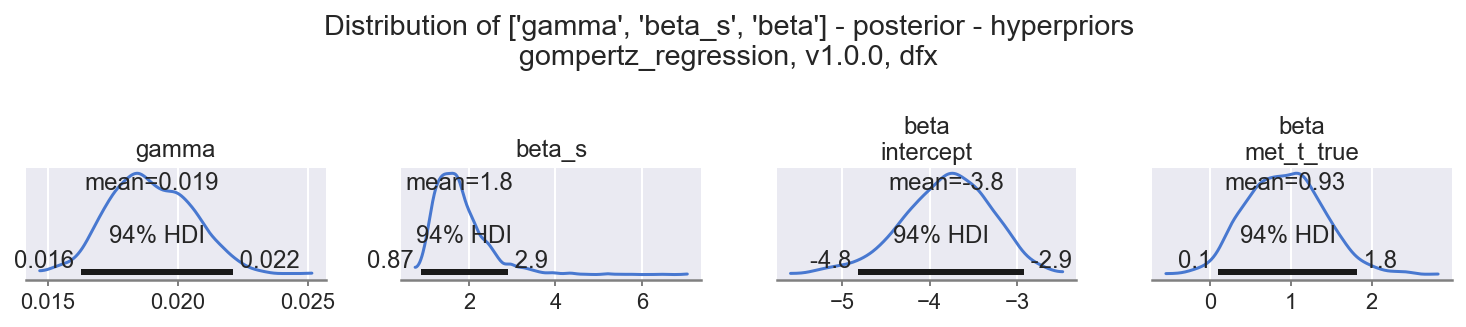

In [25]:
f = mt.facetplot_krushke(mdl=mdl_gr, group=GRP, txtadd='hyperpriors', rvs=mdl_gr.rvs_prior, m=4, rvs_hack=1)

**Observe:**

+ `gamma`: $\mathbb{E} \sim 0.019$, $\text{HDI}_{94}$ narrower than prior
+ `beta_s`: $\mathbb{E} \sim 1.8$, $\text{HDI}_{94}$ quite broad
+ `beta: intercept`: $\mathbb{E} \sim -3.8$, $0 \notin \text{HDI}_{94}$! Baseline $\eta \approx 0$ later mortality
+ `beta: met_t_true`: $\mathbb{E} \sim 0.93$, $0 \notin \text{HDI}_{94}$! Substantially moves $\eta \gt 0$ to earlier mortality

Example selections of deterministic $\alpha$

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (44) in plot_posterior, generating only 40 plots
  warnings.warn(


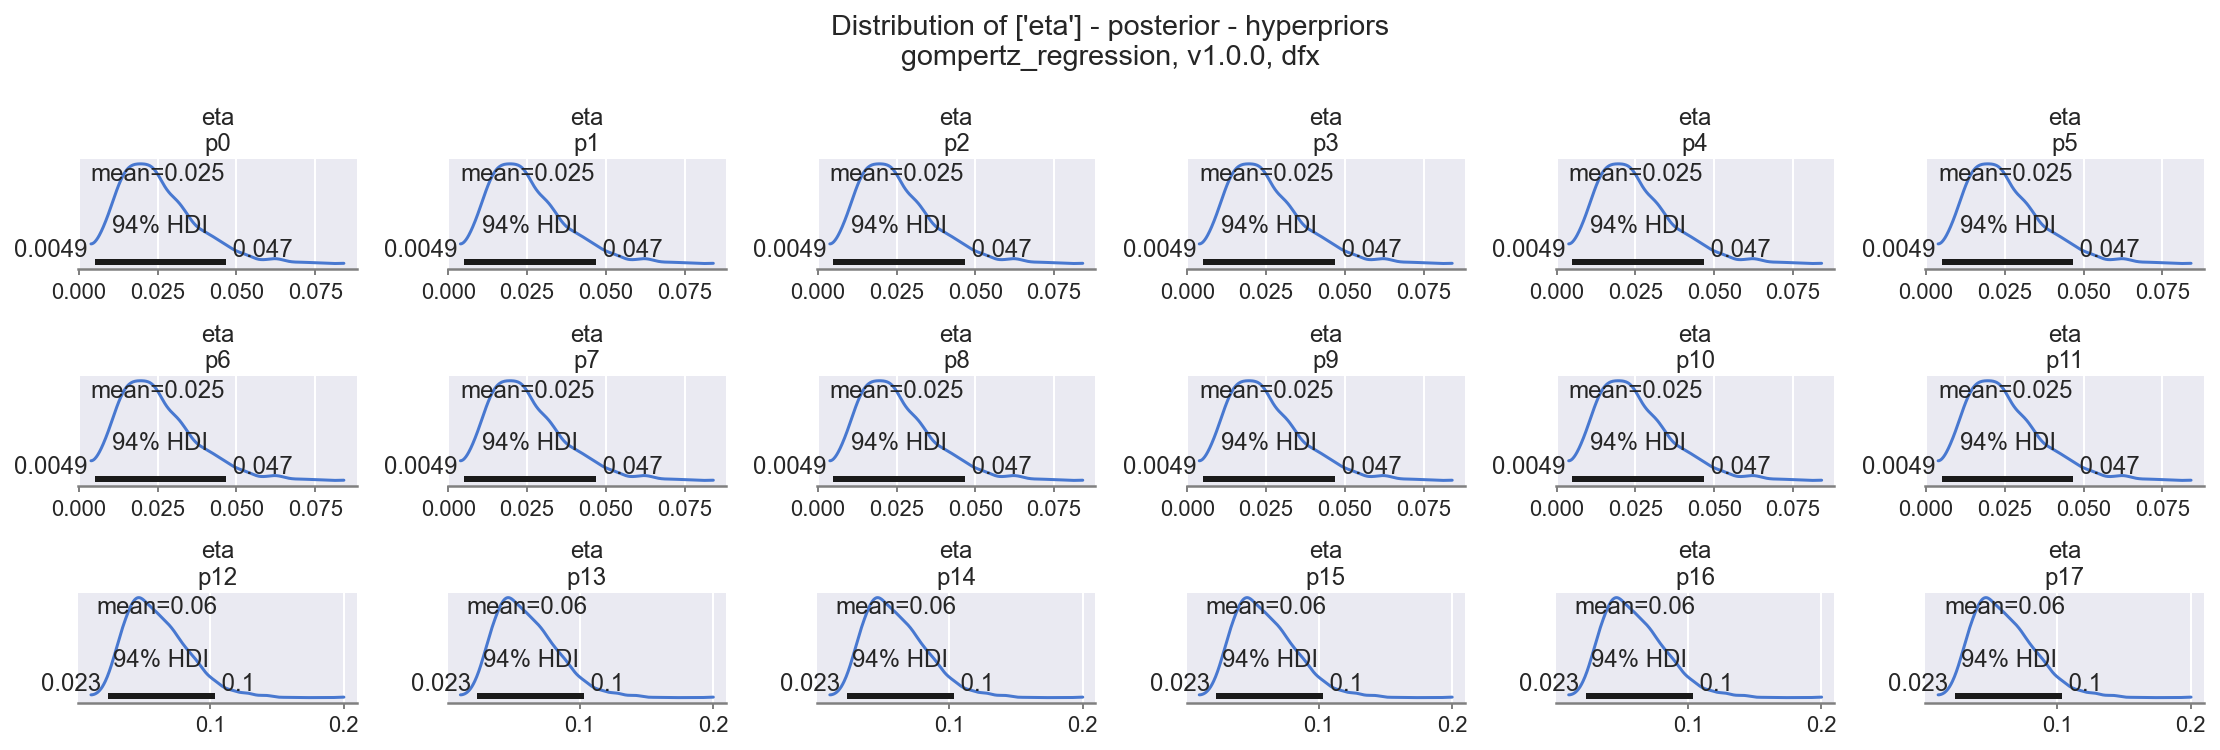

In [26]:
f = mt.facetplot_krushke(mdl=mdl_gr, group=GRP, txtadd='hyperpriors', rvs=mdl_gr.rvs_det, m=6, rvs_hack=2)

**Observe:**

+ Per the dataset and linear model formulation, there's only two groups in here, explained by `met_t_true`. The first 12 are `met_t_true=0`, and the rest (not all are shown for brevity) are `met_t_true=1`
+ As the posteriors on $\beta$ indicated, when `met_t_true=1`, $\eta > 0$, which means mortality is higher at the start of the observation period

### 2.7.2 Special look at `eta` vs `gamma`

[Missov et al 2015](https://www.demographic-research.org/articles/volume/32/36/), state that $\eta$ and $\gamma$ are
strongly correlated (which can make sampling difficult) and suggest an alternative paramterizaton using a modal value $M$.

We demo that Alternative Parameterization in `202_AFT_GompertzAlt.ipynb`, but for now let's see if the posterior samples
of `eta` and `gamma` are correlated.

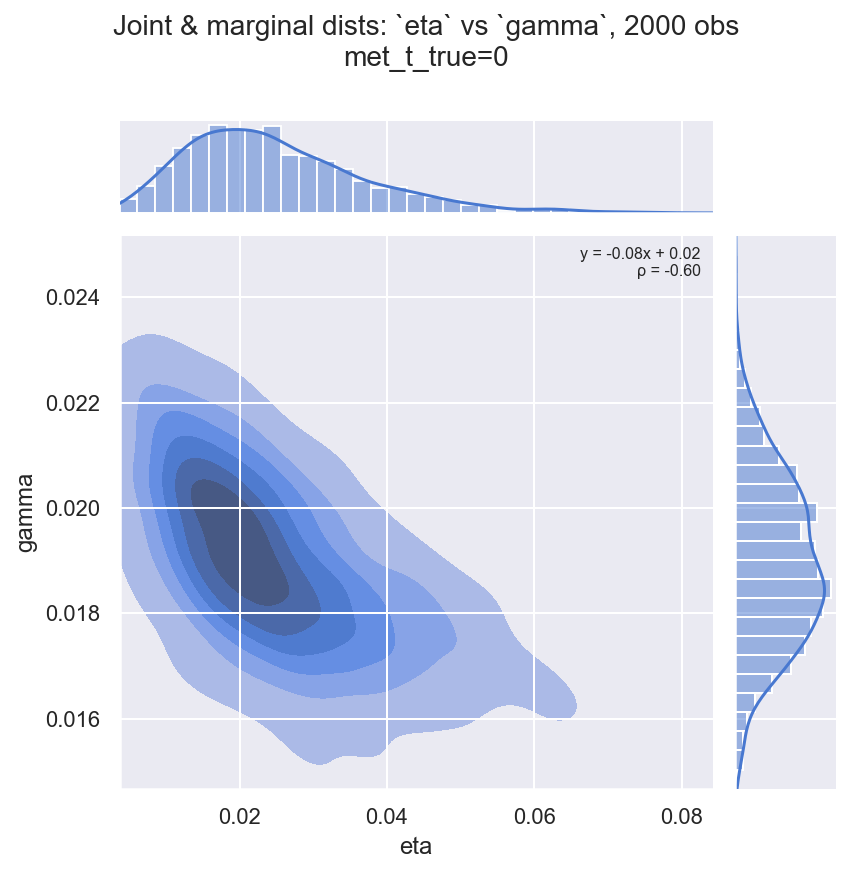

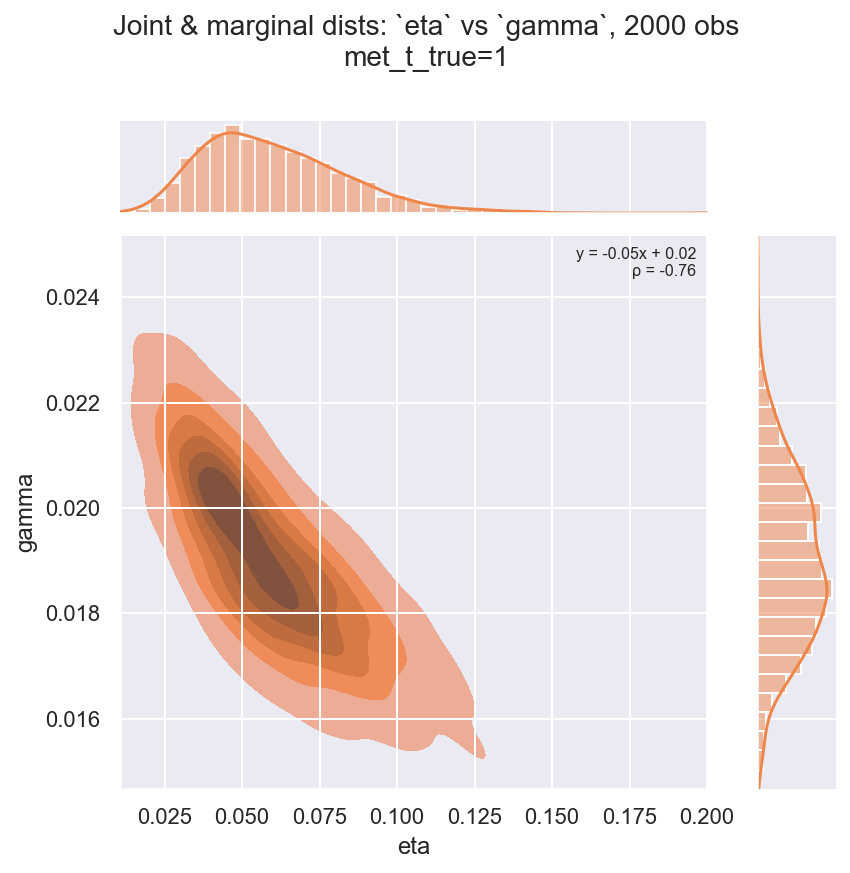

In [27]:
df_eta = az.extract(mdl_gr.idata, group='posterior', var_names='eta').to_dataframe()[['eta']]
df_gamma = az.extract(mdl_gr.idata, group='posterior', var_names='gamma').to_dataframe()[['gamma']]
df_eta0_gamma = pd.merge(df_eta.loc['p0'], df_gamma, how='outer', left_index=True, right_index=True)
df_eta1_gamma = pd.merge(df_eta.loc['p12'], df_gamma, how='outer', left_index=True, right_index=True)
f = eda.plot_joint_numeric(df_eta0_gamma, ft0='eta', ft1='gamma', txtadd='met_t_true=0')
f = eda.plot_joint_numeric(df_eta1_gamma, ft0='eta', ft1='gamma', txtadd='met_t_true=1', colori=1)

**Observe:**

+ Indeed, wesee the posteriors for `eta` and `gamma` are quite tightly (and negatively) correlated
+ This does go some way to encouraging our use of the $M$ alterantive parameterisation in `202_AFT_GompertzAlt.ipynb`

## 2.8 Forecast Survival $\hat{S}(t)$ and Expected Time-to-Event $\hat{\mathbb{E}}_{t}$

Because this model is parametric, we can **forecast** Survival $\hat{S}(t)$ and Expected Time-to-Event 
  $\hat{\mathbb{E}}_{t}$ for observations in an **out-of-sample dataset**

> See the full detailled discussion in `100_Exponential_Univariate.ipynb` $\S3.8$

### 2.8.1 Create synthetic dataset, calc PPC and extract PPC components

In [28]:
dfs = utils.get_synthetic_df_oos(df, ndur=20)
dfsx = dfx_creator.get_dfx(dfs, in_sample=False)

mdl_gr.replace_obs(obsd={'obs': dfsx}, obs_nm='dfsx')
mdl_gr.build()
f_idata = mdl_gr.sample_posterior_predictive(store_ppc=False, ppc_insample=True, var_names=mdl_gr.rvs_ppc)
dfhat = utils.get_ppc_components_as_dfm(f_idata, getx=True)
dfp = pd.merge(dfhat, dfs.reset_index(), how='left', left_on='oid', right_on='pid')
eda.display_ht(dfp)

Output()

,oid,chain,draw,shat,that,oid_sub,t,intercept,met_t_true,pid,met,death,duration
0,z000-0,0,0,1.00,219.0,z000,0,1.0,0.0,z000-0,False,False,0
1,z000-0,0,1,1.00,102.0,z000,0,1.0,0.0,z000-0,False,False,0
2,z000-0,0,2,1.00,93.0,z000,0,1.0,0.0,z000-0,False,False,0
79997,z001-226,3,497,0.02,146.0,z001,226,1.0,1.0,z001-226,True,False,226
79998,z001-226,3,498,0.02,194.0,z001,226,1.0,1.0,z001-226,True,False,226
79999,z001-226,3,499,0.01,148.0,z001,226,1.0,1.0,z001-226,True,False,226


'Shape: (80000, 13), Memsize 8.3 MB'

### 2.8.2 Plot estimated Survival $\hat{S}(t)$

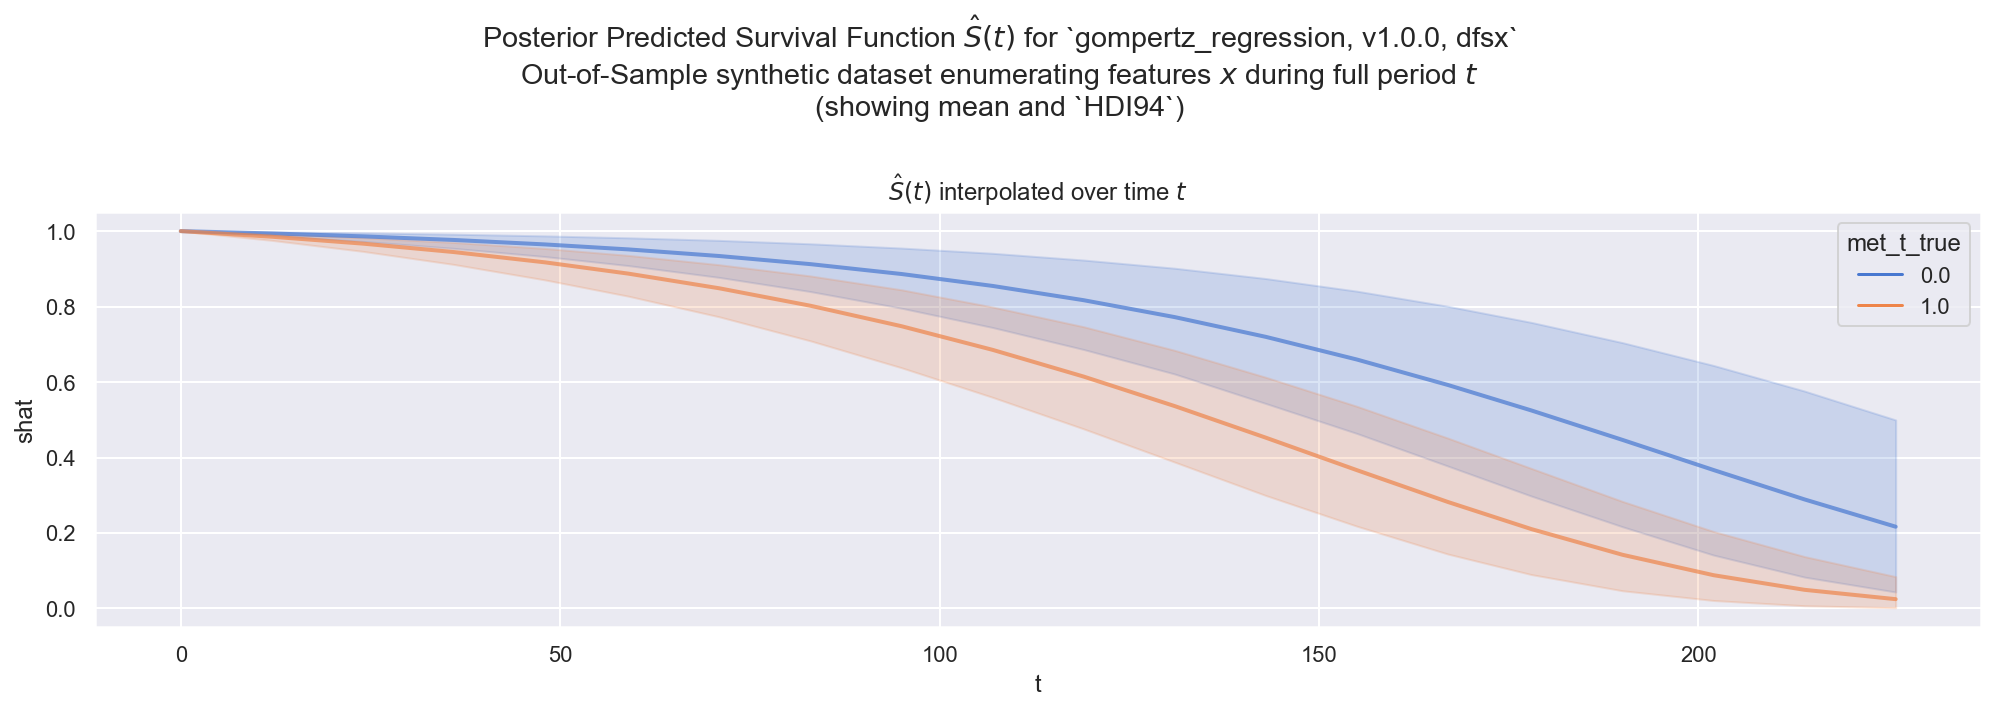

In [29]:
f, axs = plt.subplots(1, 1, figsize=(14, 5), sharex=False)
ax = sns.lineplot(x='t', y='shat',  hue='met_t_true', style='met_t_true', data=dfp, ms=10, dashes=False, 
        alpha=0.7, legend=True, lw=2, ax=axs, estimator='mean', errorbar=('pi', 94), err_style='band')
_ = ax.set_title('$\hat{{S}}(t)$ interpolated over time $t$')
_ = f.suptitle(f'Posterior Predicted Survival Function $\hat{{S}}(t)$ for `{mdl_gr.mdl_id}`'
            + '\nOut-of-Sample synthetic dataset enumerating features $x$ during full period $t$'
            + '\n(showing mean and `HDI94`)')
_ = f.tight_layout()
fqn = figio.write(f, fn=f'201_{mdl_gr.mdl_id}_forecast_shat')

### 2.8.3 Plot estimated Expected Time-to-Event $\hat{\mathbb{E}}_{t}$

We will only use Option A: Based on idealised parametric $\hat{\mathbb{E}}_{t} \sim S^{-1}(u) \sim 1/\gamma \log (1 - \log(u) / \eta)$

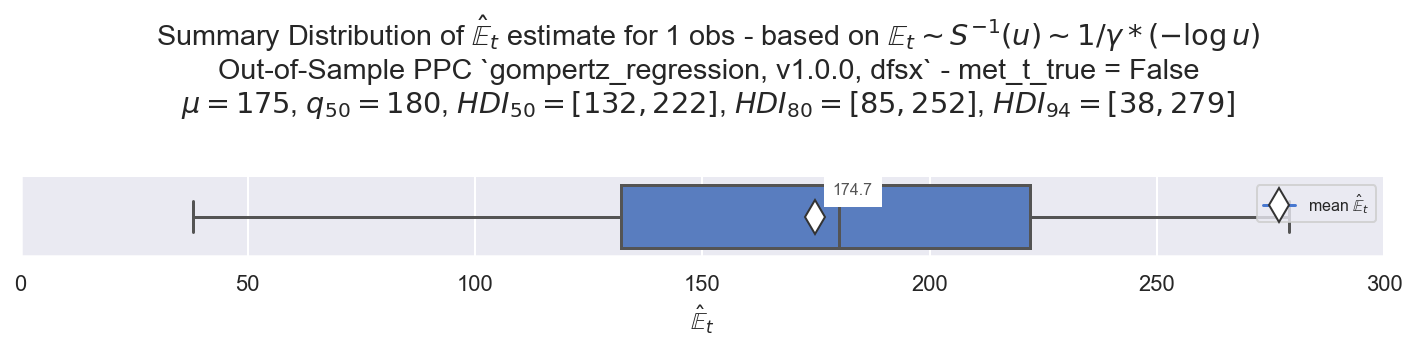

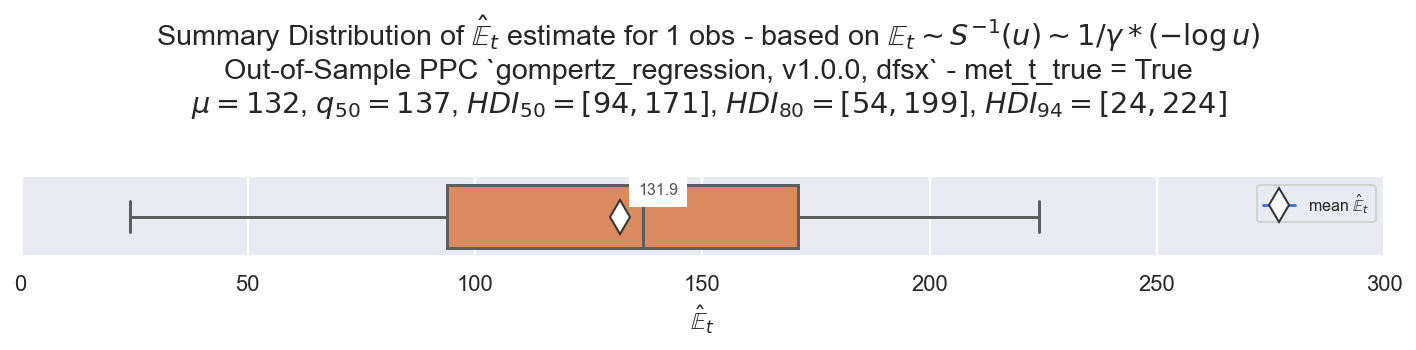

In [30]:
df_et = dfp.loc[dfp['t']==0].groupby(['pid', 'chain', 'draw', 'met_t_true'])['that'].mean().to_frame('$\hat{\mathbb{E}}_{t}$')

f = eda.plot_estimate(df=df_et.loc[:, :, :, 0], nobs=1, yhat='$\hat{\mathbb{E}}_{t}$',
    txtadd=(f'based on $\mathbb{{E}}_{{t}} \sim S^{{-1}}(u) \sim 1/\gamma * (− \log u )$'
    +f'\nOut-of-Sample PPC `{mdl_gr.mdl_id}` - met_t_true = False'), force_xlim=(0, 300))
fqn = figio.write(f, fn=f'201_{mdl_gr.mdl_id}_forecast_et_met_false')

f = eda.plot_estimate(df=df_et.loc[:, :, :, 1], nobs=1, yhat='$\hat{\mathbb{E}}_{t}$',
    txtadd=(f'based on $\mathbb{{E}}_{{t}} \sim S^{{-1}}(u) \sim 1/\gamma * (− \log u )$'
    +f'\nOut-of-Sample PPC `{mdl_gr.mdl_id}` - met_t_true = True'), force_xlim=(0, 300), color='C1')
fqn = figio.write(f, fn=f'201_{mdl_gr.mdl_id}_forecast_et_met_true')

**Observe:**

+ The distributions of forecasted expected survival times $\hat{\mathbb{E}}_{t}$ for our **synthetic out-of-sample dataset** 
  dont look great with this model:
  + For `met = False`: $\hat{\mathbb{E}}_{t} \sim 175 \in [38, 279]_{HDI94}$ days
  + For `met = True`: $\hat{\mathbb{E}}_{t} \sim 132 \in [24, 224]_{HDI94}$ days
+ These empirical predicted distributions are both substantially higher than any other model so far, no doubt due to the
  forced assumptions of the Gompertz

---

---

# Notes

In [31]:
%load_ext watermark
%watermark -a "jonathan.sedar@oreum.io" -udtmv -iv -p pymc,pytensor

Author: jonathan.sedar@oreum.io

Last updated: 2024-11-18 17:59:44

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.29.0

pymc    : 5.16.2
pytensor: 2.25.5

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
scipy     : 1.14.1
arviz     : 0.20.0
pyprojroot: 0.3.0
pandas    : 2.2.3
seaborn   : 0.12.2
sys       : 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25) [Clang 17.0.6 ]
oreum_core: 0.9.7
matplotlib: 3.9.2



---
**Oreum OÜ &copy; 2024**